## Economic complexity codes by Hossein


-   Introduction to trade data

-   Calculating RCAs, co-occurences and proximities (trade + patent data)

-   Product space visualization

-   Calculating Product Complexity / Economic Complexity (by destination)



## Trade data

### Background



The product space is, as well as its derivations / related measures such as economic complexity and the Growth&rsquo;s annual rankings of countries by economic complexity (at [https://atlas.cid.harvard.edu](https://atlas.cid.harvard.edu)), are based on trade data between countries.

The Growth Lab maintains and periodically updates a cleaned version of trade data at Harvard Dataverse:

[https://dataverse.harvard.edu/dataverse/atlas](https://dataverse.harvard.edu/dataverse/atlas)

This dataset contains bilateral trade data among 235 countries and territories in thousands of different products categories (a description of the data can be found at: [http://atlas.cid.harvard.edu/downloads](http://atlas.cid.harvard.edu/downloads)).

How does the data look like? We will explore the data in Python using the &rsquo;pandas&rsquo; (most popular Python package for data analysis).

#### Footnote on trade and services (ICT, tourism, etc.):



-   Services and tourism are included in the Growth Lab&rsquo;s Atlas and trade data as well as of September 2018. See announcement at:

[https://atlas.cid.harvard.edu/announcements/2018/services-press-release](https://atlas.cid.harvard.edu/announcements/2018/services-press-release)

Obtained from IMF, trade in services covers four categories of economic activities between producers and consumers across borders:

-   services supplied from one country to another (e.g. call centers)
-   consumption in other countries (e.g. international tourism)
-   firms with branches in other countries (e.g. bank branches overseas)
-   individuals supplying services in another country (e.g. IT consultant abroad)

### Load necessary Python libraries

In [ ]:
# -- Global settings
# - import python libraries necessary for this workshop
# suppress warnings on google colab for now
import warnings
warnings.filterwarnings("ignore")
# to interact with os, e.g. to execute shell comands such as 'ls', 'pwd' etc.
import os
# to do data processing
import pandas as pd
# backend of pandas, working with matrices
import numpy as np
# to visualize data (in pandas)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
# to process a json file
import json
# work with regex in python
import re
# work with networks in python, to create product space
import networkx as nx
# python tools to work with combinations of arrays
from itertools import count
from itertools import combinations
from itertools import product
# to run regressions
import statsmodels.api as sm
# to download files
import urllib.request, json
# to plot data on maps
# pip install is needed on Google Colab
!pip3 install geopandas
import geopandas
# -- set scientific notation to display numbers fully rather than exponential
pd.set_option('display.float_format', '{:.2f}'.format)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # Show all results of jupyter
import seaborn as sns
sns.set_style('whitegrid') # Display grids on dark background
# Enlarged pandas display - more colums and rows with greater width
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth',300)
print('necessary libraries loaded')

  Using cached geopandas-0.11.0-py3-none-any.whl (1.0 MB)
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Using cached pyproj-3.3.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.7 MB)
  Using cached Fiona-1.8.21-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.6 MB)
  Using cached Shapely-1.8.2-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.1 MB)
  Using cached pandas-1.4.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
  Using cached certifi-2022.6.15-py3-none-any.whl (160 kB)
  Using cached setuptools-62.6.0-py3-none-any.whl (1.2 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached attrs-21.4.0-py2.py3-none-any.whl (60 kB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached numpy-1.23.0-cp38-cp38-manylinux_2_17

### Download trade dataset and load into memory

Our $X_{cpt}$ matrix.

In [2]:
# Load the necessary data into pandas

# In pandas terminilogy this is called a 'dataframe' (df)
product_classification = 'hs' # Harmonized System 1992; alternative is 'SITC - Standard Industrial Trade Classification'

N_digits = '4' # alternative is 2 or 6, the higher the more detailed product info

# Trade data: we're using s3 storage from Amazon here because we can directly download the data into pandas in Google Colab but this is no longer maintained by the Growth Lab - rather download from Dataverse.

data_url = f"https://intl-atlas-downloads.s3.amazonaws.com/country_{product_classification}product{N_digits}digit_year.csv.zip"
print('Downloading data and loading into memory')
df_orig = pd.read_csv(data_url, compression="zip", low_memory=False)

# Fix product label strings ('hs_product_name_short_en'): some products with different product codes erronuously have the same strings - remove these duplicates
# (e.g. product codes 5209 and 5211 in Zimbabwe have same product string)
# -- download original UN classification
with urllib.request.urlopen("https://comtrade.un.org/data/cache/classificationH0.json") as url:
    hs1992_json = json.loads(url.read())
dft = pd.DataFrame.from_dict(hs1992_json['results'])[['text']]
dft['hs_product_code'] = dft['text'].str.split('-').str[0].str.strip()
dft['hs_product_name_short_en'] = dft['text'].str.split('-',1).str[1].str.strip()
dft['N_dig'] = dft['hs_product_code'].str.len()
dft2 = dft[dft['N_dig']==int(N_digits)].copy()
df_orig = pd.merge(df_orig,dft2[['hs_product_code','hs_product_name_short_en']],how='left',on=f'hs_product_code') # unmerged are services (obtained from IMF)
# -- replace product name now with downloaded strings (if not missing in either)
df_orig['hs_product_name_short_en_new'] = df_orig['hs_product_name_short_en_x']
df_orig.loc[ df_orig['hs_product_name_short_en_y'].notnull(),'hs_product_name_short_en_new'] = df_orig['hs_product_name_short_en_y']
df_orig.drop(['hs_product_name_short_en_x'],axis=1,inplace=True,errors='ignore')
df_orig.drop(['hs_product_name_short_en_y'],axis=1,inplace=True,errors='ignore')
df_orig.rename(columns={f'hs_product_name_short_en_new':f'hs_product_name_short_en'}, inplace=True)

# Cross check that each row is a unique year-location-product entry
df_orig['count'] = 1
df_orig['sum'] = df_orig.groupby(['year','location_name_short_en','hs_product_name_short_en'])['count'].transform('sum')
if df_orig['sum'].max() != 1:
    print(f'duplicates found, stopping')
    stop

# rename variable names for convenience
df_orig.rename(columns={f'location_name_short_en':f'country_name'}, inplace=True)
df_orig.rename(columns={f'location_code':f'country_code'}, inplace=True)
df_orig.rename(columns={f'hs_product_code':f'product_code'}, inplace=True)
df_orig.rename(columns={f'hs_product_name_short_en':f'product_name'}, inplace=True)

# Keep only relevant columns
df_orig = df_orig[['year',
         'country_code',
         'country_name',
         'product_code',
         'product_name',
         'export_value']]

print('trade dataset \'df_orig\' ready')

trade dataset 'df_orig' ready


### Exploring the trade data

#### Structure of dataset

In [3]:
# show 5 random rows
df_orig.sample(n=5)

,year,country_code,country_name,product_code,product_name,export_value
3461516,1999,SGP,Singapore,6107,"Underpants, briefs, nightshirts, pyjamas, bathrobes, dressing gowns and similar articles; men's or boys', knitted or crocheted",5658255.00
2568744,2013,LBR,Liberia,4403,"Wood in the rough, whether or not stripped of bark or sapwood, or roughly squared",51103456.00
4541981,2015,DNK,Denmark,7609,"Aluminium; tube or pipe fittings (eg couplings, elbows, sleeves)",1573574.00
1846952,2009,COM,Comoros,3101,"Fertilizers; animal or vegetable, whether or not mixed together or chemically treated; fertilizers produced by the mixing or chemical treatment of animal or vegetable products",0.00
3536789,2015,PNG,Papua New Guinea,6205,Shirts; men's or boys' (not knitted or crocheted),4421.00


#### What years are in the data?

In [4]:
df_orig['year'].unique()

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

#### How many products are in the data?

In [5]:
df_orig['product_name'].nunique()

1248

#### Finding specific countries / products based on partial string matching

If you&rsquo;re interested in finding data on certain countries / products but not sure how exactly these are spelled in the data (or are spelled with / without e.g. capital letters).

In [6]:
STRING = 'Netherland'
df_orig[df_orig['country_name'].str.contains(STRING)][['country_name']].drop_duplicates()

# You can also include regex expressions here, e.g. to ignore lower/uppercase ('wine' vs 'Wine')
STRING = 'wine'
df_orig[df_orig['product_name'].str.contains(STRING,flags=re.IGNORECASE, regex=True)][['product_name']].drop_duplicates()

,country_name
132,Netherlands Antilles
3143,Netherlands


,product_name
10074,Swine; live
40293,"Meat of swine; fresh, chilled or frozen"
55402,"Edible offal of bovine animals, swine, sheep, goats, horses, asses, mules or hinnies; fresh, chilled or frozen"
921288,"Wine of fresh grapes, including fortified wines; grape must other than that of heading no. 2009"
926325,"Vermouth and other wine of fresh grapes, flavoured with plants or aromatic substances"
981731,Wine lees; argol
3266401,"Twine, cordage, ropes and cables, whether or not plaited or braided; whether or not impregnated, coated, covered or sheathed with rubber or plastics"
3271438,"Twine, cordage or rope; knotted netting, made up fishing nets and other made up nets, of textile materials"
3276475,"Articles of yarn, strip or the like of heading no. 5404 or 5405; twine, cordage, rope or cables n.e.s. or included"
3644176,"Rags; used or new, scrap twine, cordage, rope and cables and worn out articles of twine, cordage, rope or cables, of textile materials"


#### Example: What were the major export products of the USA in 2012?

In [8]:
# create a 'dataframe' called 'df2' with only exports from USA in 2012
df2 = df_orig[ (df_orig['country_code']=='USA') & (df_orig['year'] == 2012) ].copy()
# create another dataframe 'df3' that contains the sum of exports per product
df3 = df2.groupby(['product_code','product_name'],as_index=False)['export_value'].sum()
# sort
df3.sort_values(by=['export_value'],ascending=False,inplace=True)
# show first 10 rows
df3[0:10]

,product_code,product_name,export_value
1242,ict,ICT,317000000000.00
1244,travel,Travel and tourism,162000000000.00
1240,9999,Commodities not specified according to kind,106514210816.00
260,2710,"Petroleum oils, oils from bituminous minerals, not crude; preparations n.e.s. containing less than 70% petroleum oils, oils from bituminous minerals; these being the basic constituents of the preparations",101087379456.00
1241,financial,Insurance and finance,93500000000.00
1243,transport,Transport,83900000000.00
1112,8703,"Motor cars and other motor vehicles; principally designed for the transport of persons (other than those of heading no. 8702), including station wagons and racing cars",52303282176.00
1117,8708,"Motor vehicles; parts and accessories, of heading no. 8701 to 8705",39675609088.00
1094,8542,Electronic integrated circuits and microassemblies,36943609856.00
1127,8802,"Aircraft; (eg helicopters, aeroplanes), spacecraft (including satellites) and spacecraft launch vehicles",32980711424.00


#### Example: How did exports of Cars evolve over time in the USA?

From about 10 billion USD up to almost $60 billion USD.

<AxesSubplot:xlabel='year'>

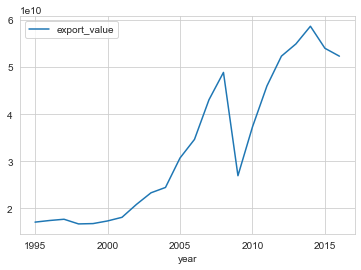

In [9]:
df2 = df_orig[ (df_orig['country_code']=='USA')].copy()
#df3 = df2[df2['product_name']=='Cars']
df3 = df2[df2['product_code']=='8703']
df3.plot(x='year', y='export_value')

## Revealed comparative advantage (RCA)

What products are countries specialized in? For that, following Hidalgo et al. (2007), we calculate the Revealed Comparative Advantage (RCA) of each country-product pair: how much a country &rsquo;over-exports&rsquo; a product in comparison to all other countries.

Technically this is the Balassa index of comparative advantage, calculated as follows for product $p$ and country $c$ at time $t$:

\begin{equation} \label{e_RCA}
{RCA}_{cpt}=\frac{X_{cpt}/X_{ct}}{X_{pt}/X_{t}}
\tag{1}
\end{equation}

where $X_{cpt}$ represents the total value of country $c$’s exports of product $p$ at time $t$ across all importers. An omitted subscript indicates a summation over the omitted dimension, e.g.: $X_{t}=\sum \limits_{c,p,t} X_{cpt}$.

A product-country pair with $RCA>1$ means that the product is over-represented in the country&rsquo;s export basket.

We use the original trade dataset (&rsquo;df<sub>orig</sub>&rsquo;) that is loaded into memory:

In [10]:
def calc_rca(data,country_col,product_col,time_col,value_col):
    """
    Calculates Revealed Comparative Advantage (RCA) of country-product-time combinations

    Returns:
        pandas dataframe with RCAs
    """

    # Aggregate to country-product-time dataframe
    print('creating all country-product-time combinations')
    # - add all possible products for each country with export value 0
    # - else matrices later on will have missing values in them, complicating calculations
    df_all = pd.DataFrame(list(product(data[time_col].unique(), data[country_col].unique(),data[product_col].unique())))
    df_all.columns=[time_col,country_col,product_col]
    print('merging data in')
    df_all = pd.merge(df_all,data[[time_col,country_col,product_col,value_col]],how='left',on=[time_col,country_col,product_col])
    df_all.loc[df_all[value_col].isnull(),value_col] = 0

    # Calculate the properties
    print('calculating properties')
    df_all['Xcpt'] = df_all[value_col]
    df_all['Xct'] = df_all.groupby([country_col, time_col])[value_col].transform(sum)
    df_all['Xpt'] = df_all.groupby([product_col, time_col])[value_col].transform(sum)
    df_all['Xt'] = df_all.groupby([time_col])[value_col].transform('sum')
    df_all['RCAcpt'] = (df_all['Xcpt']/df_all['Xct'])/(df_all['Xpt']/df_all['Xt'])
    # set to 0 if missing, e.g. if product / country have 0 (total) exports
    df_all.loc[df_all['RCAcpt'].isnull(),'RCAcpt'] = 0
    # drop the properties 
    df_all.drop(['Xcpt','Xct','Xpt','Xt'],axis=1,inplace=True,errors='ignore')

    return df_all

df_rca = calc_rca(data=df_orig,country_col='country_name',product_col='product_name',time_col='year',value_col='export_value')

print('rca dataframe ready')

# show results
df_rca[0:10]

creating all country-product-time combinations
merging data in
calculating properties
rca dataframe ready


,year,country_name,product_name,export_value,RCAcpt
0,1995,Aruba,"Horses, asses, mules and hinnies; live",18000.00,0.08
1,1995,Aruba,Bovine animals; live,0.00,0.00
2,1995,Aruba,Swine; live,0.00,0.00
3,1995,Aruba,Sheep and goats; live,0.00,0.00
4,1995,Aruba,"Poultry; live, fowls of the species gallus domesticus, ducks, geese, turkeys and guinea fowls",0.00,0.00
5,1995,Aruba,"Animals, n.e.s. in chapter 01; live",2473.00,0.03
6,1995,Aruba,Meat of bovine animals; fresh or chilled,0.00,0.00
7,1995,Aruba,Meat of bovine animals; frozen,0.00,0.00
8,1995,Aruba,"Meat of swine; fresh, chilled or frozen",0.00,0.00
9,1995,Aruba,"Meat of sheep or goats; fresh, chilled or frozen",0.00,0.00


Note: You can operate (more) directly on matrices with NumPy (Pandas is built on NumPy), e.g. to calculate RCA:

    Xc = np.sum(Xcp, axis=1)
    Xp = np.sum(Xcp, axis=0)
    X = np.sum(Xcp)
    RAC_mat = np.copy(Xcp)
    for i in range(len(RAC_mat)):
        RAC_mat[i, :] = RAC_mat[i, :] / Xc[i]
    # products / countries with no exports
    RAC_mat[np.isnan(RAC_mat)] = 0
    RAC_mat = np.transpose(RAC_mat)
    for i in range(len(RAC_mat)):
        RAC_mat[i, :] = RAC_mat[i, :] / (Xp[i] / X)

### Example: What products are The Netherlands and Saudi Arabia specialized in, in 2000?

(Note that different commands are chained together here; can also be ran separately)

In [11]:
# The Netherlands
print("\n The Netherlands: \n")

df_rca[ (df_rca['year']==2000) & (df_rca['country_name']=='Netherlands')].sort_values(by=['RCAcpt'],ascending=False)[['product_name','RCAcpt','year']][0:5]

print("\n Saudi Arabia:\n")

# Saudi Arabia
df_rca[ (df_rca['year']==2000) & (df_rca['country_name']=='Saudi Arabia')].sort_values(by=['RCAcpt'],ascending=False)[['product_name','RCAcpt','year']][0:5]


 The Netherlands: 



,product_name,RCAcpt,year
1692332,"Bulbs, tubers, tuberous roots, corms, crowns and rhizomes; dormant, in growth or in flower; chicory plants and roots other than roots of heading no. 1212",24.63,2000
1692334,"Flowers; cut flowers and flower buds of a kind suitable for bouquets or for ornamental purposes, fresh, dried, dyed, bleached, impregnated or otherwise prepared",17.00,2000
1692446,"Cocoa; powder, not containing added sugar or other sweetening matter",13.80,2000
1692333,"Plants, live; n.e.s. in heading no. 0601, (including their roots) cuttings and slips; mushroom spawn",12.64,2000
1692836,"Composite paper and paperboard, (made by sticking layers together with an adhesive), not surface-coated or impregnated, whether or not internally reinforced, in rolls or sheets",11.34,2000



 Saudi Arabia:



,product_name,RCAcpt,year
1721319,"Ethers, ether-alcohols, ether-phenols, ether-alcohol-phenols, alcohol peroxides, ether peroxides, ketone peroxides (chemically defined or not); halogenated, sulphonated, nitrated, nitrosated derivative",17.47,2000
1721252,Petroleum oils and oils obtained from bituminous minerals; crude,15.21,2000
1721315,"Acyclic alcohols and their halogenated, sulphonated, nitrated or nitrosated derivatives",12.20,2000
1721359,"Fertilizers; animal or vegetable, whether or not mixed together or chemically treated; fertilizers produced by the mixing or chemical treatment of animal or vegetable products",8.44,2000
1721195,"Sulphur of all kinds; other than sublimed, precipitated and colloidal sulphur",8.00,2000


## Product proximity (based on co-occurences)

### Calculating product co-occurences and proximities

Knowing which countries are specialized in which products, the next step analyzes the extent to which two products are over-represented ($RCA>1$) in the same countries.

As noted in the lecture, the main insight supporting this inference is that countries will produce combinations of products that require similar capabilities.

Hence we infer capabilities from trade patterns, because the capabilities of a country is a priori hard to determine and capabilities themselves are hard to observe.

Hence, **the degree to which two products cooccur in the export baskets of the same countries provides an indication of how similar the capability requirements of the two products are**.

We will calculate the co-occurence matrix of products below.

First, a product is &rsquo;present&rsquo; in a country if the country exports the product with $RCA>1$:

\begin{equation} \label{e_presence}
M_{cp}=\begin{cases}
    1 & \text{if ${RCA}_{cp}>1$}; \\
    0 & \text{elsewhere.}
    \end{cases}
\tag{2}
\end{equation}

In [12]:
df_rca['Mcp'] = 0
df_rca.loc[df_rca['RCAcpt']>1,'Mcp'] = 1

Next, we calculate how often two products are present in the same countries, using the Mcp threshold:

\begin{equation} \label{e_cooc}
C_{pp'}=\sum \limits_{c} M_{cp} M_{cp'}
\tag{3}
\end{equation}

To get an accurate value of product proximity, we need to correct these numbers for the extent to which products are present in general in trade flows between countries. To do so, Hidalgo et al. (2007) calculate product proximity as follows, defining it as the minimum of two conditional probabilities:

\begin{equation}
C_{ppt'}  = \min \left( \frac{C_{pp'}}{C_{p}},\frac{C_{pp'}}{C_{p'}} \right)
\tag{4}
\end{equation}

The minimum here is used to elimate a &rsquo;false positive&rsquo;.

Hence we correct for how prevalent specialization in product $i$ and product $j$ is across countries (i.e. the &rsquo;ubiquity&rsquo; of the products).

We will use the first year of data in the dataset, **1995,** below.

Note that to reduce yearly votality, Hidalgo et al. (2007) aggregate the trade data across multiple years (1998-2000) when calculating RCAs and product proximities for the product space. (However, when comparing the product space across years, they do use individual years).

In [13]:
def calc_cppt(data,country_col,product_col):
    """
    Calculates product co-occurences in countries

    Returns:
        pandas dataframe with co-occurence value for each product pair
    """

    # Create combinations within country_col (i.e. countries) of entities (i.e. products)
    dft = (data.groupby(country_col)[product_col].apply(lambda x: pd.DataFrame(list(combinations(x,2))))
            .reset_index(level=1, drop=True)
            .reset_index())
    dft.rename(columns={0:f'{product_col}_1'}, inplace=True)
    dft.rename(columns={1:f'{product_col}_2'}, inplace=True)

    # Create second half of matrix (assymmetrical):
    # -- {product_col} 1 X {product_col} 2 == {product_col} 2 X {product_col} 1
    dft2 = dft.copy()
    dft2.rename(columns={f'{product_col}_1':f'{product_col}_2t'}, inplace=True)
    dft2.rename(columns={f'{product_col}_2':f'{product_col}_1'}, inplace=True)
    dft2.rename(columns={f'{product_col}_2t':f'{product_col}_2'}, inplace=True)
    # -- add second half
    dft3 = pd.concat([dft,dft2],axis=0,sort=False)

    # Drop diagonal if present
    dft3 = dft3[ dft3[f'{product_col}_1'] != dft3[f'{product_col}_2'] ]

    # Now calculate N of times that {product_col}s occur together
    dft3['count'] = 1
    dft3 = dft3.groupby([f'{product_col}_1',f'{product_col}_2'],as_index=False)['count'].sum()
    dft3.rename(columns={f'count':f'Cpp'}, inplace=True)

    # Calculate ubiquity
    df_ub = data.groupby(product_col,as_index=False)['Mcp'].sum()
    # Merge ubiqity into cpp matrix
    df_ub.rename(columns={f'{product_col}':f'{product_col}_1'}, inplace=True)
    dft3 = pd.merge(dft3,df_ub,how='left',on=f'{product_col}_1')
    df_ub.rename(columns={f'{product_col}_1':f'{product_col}_2'}, inplace=True)
    dft3 = pd.merge(dft3,df_ub,how='left',on=f'{product_col}_2')

    # Take minimum of conditional probabilities
    dft3['kpi'] = dft3['Cpp']/dft3['Mcp_x']
    dft3['kpj'] = dft3['Cpp']/dft3['Mcp_y']
    dft3['phi'] = dft3['kpi']
    dft3.loc[dft3['kpj']<dft3['kpi'],'phi'] = dft3['kpj']

    return dft3

# Keep only year 1995
dft = df_rca[df_rca['year']==1995].copy()

# Keep only country-product combinations where Mcp == 1 (thus RCAcp > 1)
dft = dft[dft['Mcp']==1]

# Calculate cpp
df_cppt = calc_cppt(dft,country_col='country_name',product_col='product_name')

print('cppt product co-occurences and proximities dataframe ready')

cppt product co-occurences and proximities dataframe ready


#### Products that co-occur most often

In [14]:
df_cppt.sort_values(by=['Cpp'],ascending=False)[0:10]

,product_name_1,product_name_2,Cpp,Mcp_x,Mcp_y,kpi,kpj,phi
1149849,"Suits, ensembles, jackets, blazers, trousers, bib and brace overalls, breeches and shorts (other than swimwear); men's or boys' (not knitted or crocheted)","Suits, ensembles, jackets, dresses, skirts, divided skirts, trousers, bib and brace overalls, breeches and shorts (other than swimwear); women's or girls' (not knitted or crocheted)",59,68,70,0.87,0.84,0.84
1153522,"Suits, ensembles, jackets, dresses, skirts, divided skirts, trousers, bib and brace overalls, breeches and shorts (other than swimwear); women's or girls' (not knitted or crocheted)","Suits, ensembles, jackets, blazers, trousers, bib and brace overalls, breeches and shorts (other than swimwear); men's or boys' (not knitted or crocheted)",59,70,68,0.84,0.87,0.84
589806,ICT,Travel and tourism,59,82,86,0.72,0.69,0.69
1270771,Travel and tourism,ICT,59,86,82,0.69,0.72,0.69
1271357,Travel and tourism,Transport,57,86,86,0.66,0.66,0.66
1270116,Transport,Travel and tourism,57,86,86,0.66,0.66,0.66
1153464,"Suits, ensembles, jackets, dresses, skirts, divided skirts, trousers, bib and brace overalls, breeches and shorts (other than swimwear); women's or girls' (not knitted or crocheted)",Shirts; men's or boys' (not knitted or crocheted),55,70,70,0.79,0.79,0.79
1081059,Shirts; men's or boys' (not knitted or crocheted),"Suits, ensembles, jackets, dresses, skirts, divided skirts, trousers, bib and brace overalls, breeches and shorts (other than swimwear); women's or girls' (not knitted or crocheted)",55,70,70,0.79,0.79,0.79
1149789,"Suits, ensembles, jackets, blazers, trousers, bib and brace overalls, breeches and shorts (other than swimwear); men's or boys' (not knitted or crocheted)",Shirts; men's or boys' (not knitted or crocheted),53,68,70,0.78,0.76,0.76
1081056,Shirts; men's or boys' (not knitted or crocheted),"Suits, ensembles, jackets, blazers, trousers, bib and brace overalls, breeches and shorts (other than swimwear); men's or boys' (not knitted or crocheted)",53,70,68,0.76,0.78,0.76


#### Most proximate products

In [15]:
df_cppt.sort_values(by=['phi'],ascending=False)[0:10]

,product_name_1,product_name_2,Cpp,Mcp_x,Mcp_y,kpi,kpj,phi
690963,"Machine-tools; (including machines for nailing, stapling, glueing or otherwise assembling) for working wood, cork, bone, hard plastics or rubber or similar hard materials","Machines; calendering or other rolling machines, for other than metal or glass and cylinders therefor",9,10,10,0.90,0.90,0.90
723013,"Machines; calendering or other rolling machines, for other than metal or glass and cylinders therefor","Machine-tools; (including machines for nailing, stapling, glueing or otherwise assembling) for working wood, cork, bone, hard plastics or rubber or similar hard materials",9,10,10,0.90,0.90,0.90
1149849,"Suits, ensembles, jackets, blazers, trousers, bib and brace overalls, breeches and shorts (other than swimwear); men's or boys' (not knitted or crocheted)","Suits, ensembles, jackets, dresses, skirts, divided skirts, trousers, bib and brace overalls, breeches and shorts (other than swimwear); women's or girls' (not knitted or crocheted)",59,68,70,0.87,0.84,0.84
1153522,"Suits, ensembles, jackets, dresses, skirts, divided skirts, trousers, bib and brace overalls, breeches and shorts (other than swimwear); women's or girls' (not knitted or crocheted)","Suits, ensembles, jackets, blazers, trousers, bib and brace overalls, breeches and shorts (other than swimwear); men's or boys' (not knitted or crocheted)",59,70,68,0.84,0.87,0.84
324476,Cork; articles of natural cork,"Natural cork, raw or simply prepared; waste cork; crushed, granulated or ground cork",5,6,6,0.83,0.83,0.83
808540,"Natural cork, raw or simply prepared; waste cork; crushed, granulated or ground cork",Cork; articles of natural cork,5,6,6,0.83,0.83,0.83
1339374,Video recording or reproducing apparatus,Sound or video recording apparatus; parts thereof of apparatus of heading no. 8519 to 8521,10,12,12,0.83,0.83,0.83
137061,"Blouses, shirts and shirt-blouses; women's or girls', knitted or crocheted","Suits, ensembles, jackets, dresses, skirts, divided skirts, trousers, bib and brace overalls, breeches and shorts (not swimwear), women's or girls', knitted or crocheted",50,54,60,0.93,0.83,0.83
1115899,Sound or video recording apparatus; parts thereof of apparatus of heading no. 8519 to 8521,Video recording or reproducing apparatus,10,12,12,0.83,0.83,0.83
1151434,"Suits, ensembles, jackets, dresses, skirts, divided skirts, trousers, bib and brace overalls, breeches and shorts (not swimwear), women's or girls', knitted or crocheted","Blouses, shirts and shirt-blouses; women's or girls', knitted or crocheted",50,60,54,0.83,0.93,0.83


## Patents: RCAs and technology proximities

We can apply this to patent data as well.

At the Growth Lab we have access to the Patstat database as well as all patents from Google Bigquery (both are on the RC Cannon cluster).

Patstat includes all patents from ~ 1903 onwards.

Below is an outline of what is available in Patstat:

![img](https://www.dropbox.com/s/zqgv7fi61c2ip2f/patstat.png?dl=1)

Below I use an aggregated file created from the Patstat database, containing:

-   Year
-   Country
-   Technology class
-   Count (N of patents)

which I put on Dropbox temporarily so we can load it in directly in Google CoLab.

In [16]:
# Load STATA file into pandas, directly from URL
print('loading file')
dfp = pd.read_stata('https://www.dropbox.com/s/nwox3dznoupzm0q/patstat_year_country_tech_inventor_locations.dta?dl=1')
print('loaded')

# show 10 random rows from the dataset
dfp.sample(n=10)

loading file
loaded


,index,year,country_iso_code,country_name,tech,count
82093,85258,2004,THA,Thailand,Semiconductors,5
100581,103746,2012,DEU,Germany,Pharmaceuticals,7004
39557,42722,1980,TWN,Chinese Taipei,"Electrical machinery, apparatus, energy",3
57099,60264,1993,KOR,Republic of Korea,"Materials, metallurgy",321
26334,29499,1965,GBR,United Kingdom,Basic communication processes,45
117718,120883,2018,AUT,Austria,Telecommunications,225
85463,88628,2006,ESP,Spain,Textile and paper machines,253
124590,127755,2020,KOR,Republic of Korea,Organic fine chemistry,537
115433,118598,2017,FIN,Finland,Machine tools,171
36605,39770,1978,CUB,Cuba,Civil engineering,1


### RCAs

In [17]:
dfp_rca = calc_rca(data=dfp,
                   country_col='country_name',
                   product_col='tech',
                   time_col='year',
                   value_col='count')

# What were Japan and Germany specialized in, in 1960 and 2010?
for country in ['Japan','Germany']:
    for year in [1960, 2010]:
        print(f"---------")
        print(f"\n {country} in {year} \n")
        dft = dfp_rca[dfp_rca['country_name']==country].copy()
        dft = dft[dft['year']==year]
        # --
        dft.sort_values(by=['RCAcpt'],ascending=False)[0:10]

creating all country-product-time combinations
merging data in
calculating properties
---------

 Japan in 1960 



,year,country_name,tech,count,RCAcpt
433790,1960,Japan,Audio-visual technology,15.00,27.61
433799,1960,Japan,Biotechnology,9.00,25.54
433797,1960,Japan,Basic communication processes,1.00,2.70
433804,1960,Japan,Food chemistry,1.00,2.33
433808,1960,Japan,"Materials, metallurgy",3.00,1.62
433806,1960,Japan,Machine tools,4.00,1.61
433816,1960,Japan,Transport,2.00,1.08
433791,1960,Japan,Civil engineering,2.00,1.06
433800,1960,Japan,Chemical engineering,1.00,0.74
433814,1960,Japan,Textile and paper machines,2.00,0.68


---------

 Japan in 2010 



,year,country_name,tech,count,RCAcpt
834591,2010,Japan,Optics,17847.00,2.52
834570,2010,Japan,Audio-visual technology,19278.00,2.10
834594,2010,Japan,Textile and paper machines,5950.00,1.77
834602,2010,Japan,Semiconductors,17287.00,1.72
834582,2010,Japan,"Electrical machinery, apparatus, energy",20214.00,1.47
834592,2010,Japan,"Surface technology, coating",4642.00,1.39
834587,2010,Japan,"Macromolecular chemistry, polymers",5460.00,1.30
834572,2010,Japan,"Engines, pumps, turbines",5533.00,1.23
834596,2010,Japan,Transport,8340.00,1.17
834589,2010,Japan,Mechanical elements,4743.00,1.12


---------

 Germany in 1960 



,year,country_name,tech,count,RCAcpt
433216,1960,Germany,Optics,152.00,1.98
433226,1960,Germany,Digital communication,18.00,1.72
433203,1960,Germany,Basic materials chemistry,256.00,1.50
433200,1960,Germany,Other consumer goods,223.00,1.34
433207,1960,Germany,"Electrical machinery, apparatus, energy",510.00,1.33
433208,1960,Germany,Environmental technology,33.00,1.33
433212,1960,Germany,"Macromolecular chemistry, polymers",129.00,1.28
433217,1960,Germany,"Surface technology, coating",65.00,1.22
433223,1960,Germany,Analysis of biological materials,4.00,1.18
433221,1960,Germany,Transport,193.00,1.17


---------

 Germany in 2010 



,year,country_name,tech,count,RCAcpt
833994,2010,Germany,Mechanical elements,5825.00,2.17
834001,2010,Germany,Transport,9182.00,2.03
833992,2010,Germany,"Macromolecular chemistry, polymers",4796.00,1.80
833991,2010,Germany,Machine tools,4721.00,1.75
833983,2010,Germany,Basic materials chemistry,4571.00,1.69
833977,2010,Germany,"Engines, pumps, turbines",4607.00,1.60
834002,2010,Germany,Organic fine chemistry,9064.00,1.51
833978,2010,Germany,Handling,4058.00,1.38
833985,2010,Germany,Chemical engineering,3700.00,1.32
833999,2010,Germany,Textile and paper machines,2780.00,1.30


### Technology proximities

What technology classes are most proximate (in 2010)?

In [18]:
# Define Mcp
dfp_rca['Mcp'] = 0
dfp_rca.loc[dfp_rca['RCAcpt']>1,'Mcp'] = 1

# Keep only years 2010
#dft = dfp_rca[ (dfp_rca['year']>=1990) & (dfp_rca['year']<=2020)].copy()
dft = dfp_rca[ (dfp_rca['year']==2010) ].copy()

# Keep only country-product combinations where Mcp == 1 (thus RCAcp > 1)
dft = dft[dft['Mcp']==1]

# Calculate cppt
dfp_cppt = calc_cppt(dft,country_col='country_name',product_col='tech')
print('cppt patent co-occurences and proximities dataframe ready')

cppt patent co-occurences and proximities dataframe ready


In [19]:
# Show most proximate technologies
dfp_cppt.sort_values(by=['phi'],ascending=False)[0:10]

,tech_1,tech_2,Cpp,Mcp_x,Mcp_y,kpi,kpj,phi
424,Environmental technology,"Materials, metallurgy",27,38,45,0.71,0.60,0.60
656,"Materials, metallurgy",Environmental technology,27,45,38,0.60,0.71,0.60
188,Chemical engineering,"Materials, metallurgy",28,48,45,0.58,0.62,0.58
649,"Materials, metallurgy",Chemical engineering,28,45,48,0.62,0.58,0.58
676,"Materials, metallurgy",Thermal processes and apparatus,26,45,43,0.58,0.60,0.58
1137,Thermal processes and apparatus,"Materials, metallurgy",26,43,45,0.60,0.58,0.58
230,Civil engineering,Other special machines,38,66,51,0.58,0.75,0.58
920,Other special machines,Civil engineering,38,51,66,0.75,0.58,0.58
334,Digital communication,Telecommunications,21,37,31,0.57,0.68,0.57
1059,Telecommunications,Digital communication,21,31,37,0.68,0.57,0.57


You can use density regressions as well here to predict technological diversification of countries.

## Product space

### Overview



We now have a measure of similarity between products (and patents), which is the core of the product space.

[https://atlas.cid.harvard.edu/explore/network?country=114&year=2018&productClass=HS&product=undefined&startYear=undefined&target=Product&partner=undefined](https://atlas.cid.harvard.edu/explore/network?country=114&year=2018&productClass=HS&product=undefined&startYear=undefined&target=Product&partner=undefined)

![img](/home/linux/Dropbox/proj/org_zhtml_projects/product-space-eci-workshop/imgs/product_space_atlas_website.png)

![img](https://www.dropbox.com/s/izag1xf28yldanf/product_space_atlas_website.png?dl=1)

Below we will explore the product space using Python. You can then directly manipulate the product space and visualize selectively if not possible in the Atlas interface (e.g. only products exported to certain countries).

The Github repo for this is available at [https://github.com/matteha/py-productspace](https://github.com/matteha/py-productspace).

What we need is information on:

-   Edges (ties) between nodes
    
    Ties between nodes represent the product proximity calculated above. Each product pair has a proximity value, but visualizing all ties, however, would result in a major &ldquo;hairball&rdquo;.
    
    To determine which of the ties to visualize in the product space, a &rsquo;maximum spanning tree algorithm&rsquo; is used (to make sure all nodes are connected directly or indirectly) in conjunction with a certain proximity threshold (0.55 minimum conditional probability). The details can be found in the Supplementary Material of Hidalgo et al. (2007) at [https://science.sciencemag.org/content/suppl/2007/07/26/317.5837.482.DC1](https://science.sciencemag.org/content/suppl/2007/07/26/317.5837.482.DC1).
    
    The data on the ties of nodes is available in the Atlas data repository at:
    [https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/FCDZBN/QSEETD&version=1.1](https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/FCDZBN/QSEETD&version=1.1)
    
    We can directly load it into Python using the link below (temporarily for this session, when using Harvard&rsquo;s dataverse you&rsquo;d need to sign a short User Agreement form so you can&rsquo;t load data directly from a URL):
    
    [https://www.dropbox.com/s/r601tjoulq1denf/network_hs92_4digit.json?dl=1](https://www.dropbox.com/s/r601tjoulq1denf/network_hs92_4digit.json?dl=1)

-   Position of nodes
    -   Each node is a product
    
    -   To position them in the product space, Hidalgo et al. (2007) used a spring embedding algorithm (which positions the nodes in such a way that there are as few crossing ties as possible, using physical simulations with force-directed algorithms), followed by hand-crafting the outcome to further visually separate distinct &rsquo;clusters&rsquo; of products.
        
        The data on the position of nodes (x, y coordinates) is in the same file as the one above with the data on ties (network<sub>hs92</sub><sub>4digit.json</sub>).
        
        We will use this fixed layout for now (James and Yang will deal with different ways to visualize multi-dimensional data in 2D/3D, e.g. with machine learning, UMAP).

-   Size of nodes
    
    The size in the product space represents the total $ in world trade, but one can also use other attributes of nodes (e.g. if nodes are industries, the size could be total employment).

-   Color of nodes
    
    In the product space the node color represents major product groups (e.g. Agriculture, Chemicals) following the Leamer classification. The node coloring data is available in the Atlas data repository at:
    [https://dataverse.harvard.edu/dataverse/atlas?q=&types=files&sort=dateSort&order=desc&page=1](https://dataverse.harvard.edu/dataverse/atlas?q=&types=files&sort=dateSort&order=desc&page=1)
    
    We can directly load it into Python using the link below (again, temporary for this session):
    
    [https://www.dropbox.com/s/rlm8hu4pq0nkg63/hs4_hex_colors_intl_atlas.csv?dl=1](https://www.dropbox.com/s/rlm8hu4pq0nkg63/hs4_hex_colors_intl_atlas.csv?dl=1)

### Product space in Python



#### Function to create product space



The function below creates the product space. It uses the &rsquo;networkx&rsquo; package.

In [20]:
def create_product_space(df_plot_dataframe=None,
                         df_plot_node_col=None,
                         df_node_size_col=None):

    # No legend, not properly coded yet
    show_legend = 0

    # Copy dataframe so original won't be overwritten
    df_plot =  df_plot_dataframe.copy()

    NORMALIZE_NODE_SIZE = 1
    if NORMALIZE_NODE_SIZE == 1:

        """
        The distribution of export values is highly skewed, which makes it hard to visualize
        them properly (certain products will overshadow the rest of the network).


        We create a new size column below in which we normalize the export values.
        """

        ### Normalize node size (0.1 to 1)

        def normalize_col(dft,col,minsize=0.1,maxsize=1):
            """
            Normalizes column values with largest and smallest values capped at min at max
            For use in networkx

            returns pandas column
            """

            alpha = maxsize-minsize
            Xl = dft[dft[col]>0][col].quantile(0.10)
            Xh = dft[dft[col]>0][col].quantile(0.95)
            dft['node_size'] = 0
            dft.loc[ dft[col]>=Xh,'node_size'] = maxsize
            dft.loc[ (dft[col]<=Xl) & (dft[col]!=0),'node_size'] = minsize
            dft.loc[ (dft[col]<Xh) & (dft[col]>Xl),'node_size'] = ((alpha*(dft[col]-Xl))/(Xh-Xl))+(1-alpha)
            dft.loc[ (dft[col]<Xh) & (dft[col]>0),'node_size'] = ((alpha*(dft[col]-Xl))/(Xh-Xl))+(1-alpha)

            return dft['node_size']

        df_plot['node_size'] = normalize_col(df_plot,df_node_size_col,minsize=0.1,maxsize=1)

    ADD_COLORS_ATLAS = 1
    if ADD_COLORS_ATLAS == 1:

        # First add product codes from original file (full strings were used for illustrative purposes above but we need the actual codes to merge data from other sources, e.g. node colors)
        df_plot = pd.merge(df_plot,df_orig[['product_name','product_code']].drop_duplicates(),how='left',on='product_name')
        dft = pd.read_csv('https://www.dropbox.com/s/rlm8hu4pq0nkg63/hs4_hex_colors_intl_atlas.csv?dl=1')

        # Transform product_code into int (accounts for missing in pandas, if necessary)
        # keep only numeric product_codes (this drops 'unspecified' as well as services for now;
        # - as the latter needs a separate color classification)
        df_plot = df_plot[df_plot['product_code'].astype(str).str.isnumeric()]
        # -- also drop 9999 product code; unknown
        df_plot = df_plot[df_plot['product_code'].astype(str)!='9999']
        # -- to allow merge, rename and transform both variables into int
        dft['hs4'] = dft['hs4'].astype(int)
        df_plot['product_code'] = df_plot['product_code'].astype(int)
        if 'color' in df_plot.columns:
            df_plot.drop(['color'],axis=1,inplace=True,errors='ignore')
        df_plot = pd.merge(df_plot,dft[['hs4','color']],how='left',left_on='product_code',right_on='hs4')
        # drop column merged from dft
        df_plot.drop(['hs4'],axis=1,inplace=True,errors='ignore')

        # CREATE_LEGEND = 1
        # if CREATE_LEGEND == 1:
        #     # Atlas classification products
        #     df_temp = pd.read_csv('https://raw.githubusercontent.com/cid-harvard/classifications/master/product/HS/IntlAtlas/out/hs92_atlas.csv')
        #     df_temp.rename(columns={'Unnamed: 0': 'internal_code'}, inplace=True)
        #     # -- keep sections
        #     df_temp1 = df_temp[df_temp['level']=='section'].copy()
        #     # -- keep 4 digit
        #     df_temp2 = df_temp[df_temp['level']=='2digit'].copy()
        #     # -- keep 4 digit
        #     df_temp3 = df_temp[df_temp['level']=='4digit'].copy()
        #     # -- merge parent id of parent id of 4 digits (= 2digit)
        #     # ---- remake to float
        #     df_temp3['parent_id'] = df_temp3['parent_id'].astype(object)
        #     df_temp2['internal_code'] = df_temp2['internal_code'].astype(object)
        #     df_temp3t = pd.merge(df_temp3,df_temp2[['internal_code','parent_id']],how='left',left_on='parent_id',right_on='internal_code',indicator=True)
        #     # -- now merge parent_id_y to internal code of df_temp1
        #     df_temp3t.drop(['_merge'],axis=1,inplace=True)
        #     df_temp3t2 = pd.merge(df_temp3t,df_temp1[['internal_code','name']],how='left',left_on='parent_id_y',right_on='internal_code',indicator=True)
        #     # keep only relevant columns
        #     df_temp4 = df_temp3t2[['code','name_x','name_y']]
        #     df_temp5 = df_temp4[['code','name_y']]
        #     df_temp5.rename(columns={'code': 'product'}, inplace=True)
        #     df_temp5.rename(columns={'name_y': 'name_sector_atlas'}, inplace=True)
        #     # drop XXXX / services (not in product space)
        #     drop_categories = ['XXXX','unspecified','travel','transport','ict','financial']
        #     df_temp5 = df_temp5[ ~(df_temp5['product'].isin(drop_categories))]

        #     # add to df_temp_plot
        #     df_temp_plott = df_plot.copy()
        #     df_temp_plott['product_code'] = df_temp_plott['product_code'].astype(float)
        #     df_temp5['product'] = df_temp5['product'].astype(float)
        #     df_temp_plot3 = pd.merge(df_temp_plott,df_temp5,how='left',left_on='product_code',right_on='product')
        #     df_temp_plot3.drop_duplicates(subset='color',inplace=True)
        #     df_temp_plot3 = df_temp_plot3[['color','name_sector_atlas']]

        #     # create color dict for legend
        #     color_dict = {}
        #     df_temp_plot3.reset_index(inplace=True,drop=True)
        #     for ind, row in df_temp_plot3.iterrows():
        #         color_dict[row['name_sector_atlas']] = row['color']

        #     """
        #     def build_legend(data):
        #         # Build a legend for matplotlib plt from dict
        #         legend_elements = []
        #         for key in data:
        #             legend_elements.append(Line2D([0], [0], marker='o', color='w', label=key,
        #                                             markerfacecolor=data[key], markersize=10))
        #         return legend_elements
        #     fig,ax = plt.subplots(1)
        #     #ax.add_patch(rect) # Add the patch to the Axes
        #     legend_elements = build_legend(color_dict)
        #     ax.legend(handles=legend_elements, loc='upper left')
        #     plt.show()
        #     """

    ADD_NODE_POSITIONS_ATLAS = 1
    if ADD_NODE_POSITIONS_ATLAS == 1:

        # Load position of nodes (x, y coordinates of nodes from original Atlas file)
        import urllib.request, json
        with urllib.request.urlopen("https://www.dropbox.com/s/r601tjoulq1denf/network_hs92_4digit.json?dl=1") as url:
            networkjs = json.loads(url.read().decode())

    CREATE_NETWORKX_OBJECT_AND_PLOT = 1
    if CREATE_NETWORKX_OBJECT_AND_PLOT == 1:

        # Convert json into python list and dictionary
        nodes = []
        nodes_pos = {}
        for x in networkjs['nodes']:
            nodes.append(int(x['id']))
            nodes_pos[int(x['id'])] = (int(x['x']),-int(x['y']/1.5))

        # Define product space edge list (based on strength from the json)
        edges = []
        for x in networkjs['edges']:
            if x['strength'] > 1 or 1 == 1:
                edges.append((int(x['source']),int(x['target'])))
        dfe = pd.DataFrame(edges)
        dfe.rename(columns={0: 'src'}, inplace=True)
        dfe.rename(columns={1: 'trg'}, inplace=True)

        # Only select edges of nodes that are also present in product space
        dfe2 = pd.DataFrame(np.append(dfe['src'].values,dfe['trg'].values)) # (some products may not be in there)
        dfe2.drop_duplicates(inplace=True)
        dfe2.rename(columns={0: 'node'}, inplace=True)
        dfn2 = pd.merge(df_plot,dfe2,how='left',left_on=df_plot_node_col,right_on='node',indicator=True)

        # Drop products from this dataframe that are not in product space
        dfn2 = dfn2[dfn2['_merge']=='both']

        # Create networkx objects in Python

        # G object = products that will be plotted
        G=nx.from_pandas_edgelist(dfn2,'product_code','product_code')

        # G2 object = all nodes and edges from the original product space
        # - Those that are not plotted will be gray in the background,
        # - e.g. products for which there is no info
        G2=nx.from_pandas_edgelist(dfe,'src','trg')

        # Add node attributes to networkx objects
        # - Create a 'present' variable which indicates that these products are present in product space,
        # - as not all products in product space are present in the data to be plotted
        # - (e.g. because we could filter only to plot products with more than >$40 million in trade)
        df_plot['present'] = 1
        ATTRIBUTES = ['node_size'] + ['color'] + ['present']
        for ATTRIBUTE in ATTRIBUTES:
            dft = df_plot[[df_plot_node_col,ATTRIBUTE]]
            dft['count'] = 1
            dft = dft.groupby([df_plot_node_col,ATTRIBUTE],as_index=False)['count'].sum()
            #** drop if missing , and drop duplicates
            dft.dropna(inplace=True)
            dft.drop(['count'],axis=1,inplace=True)
            dft.drop_duplicates(subset=[df_plot_node_col,ATTRIBUTE],inplace=True)
            dft.set_index(df_plot_node_col,inplace=True)
            dft_dict = dft[ATTRIBUTE].to_dict()
            for i in sorted(G.nodes()):
                try:
                    #G.node[i][ATTRIBUTE] = dft_dict[i]
                    G.nodes[i][ATTRIBUTE] = dft_dict[i]
                except Exception:
                    #G.node[i][ATTRIBUTE] = 'Missing'
                    G.nodes[i][ATTRIBUTE] = 'Missing'
            for i in sorted(G2.nodes()):
                try:
                    #G2.node[i][ATTRIBUTE] = dft_dict[i]
                    G2.nodes[i][ATTRIBUTE] = dft_dict[i]
                except Exception:
                    #G2.node[i][ATTRIBUTE] = 'Missing'
                    G2.nodes[i][ATTRIBUTE] = 'Missing'

        # Cross-check that attributes have been added correctly
        # nx.get_node_attributes(G2,df_color)
        # nx.get_node_attributes(G,df_color)

        # Create color + size lists which networkx uses for plotting
        groups = set(nx.get_node_attributes(G2,'color').values())
        mapping = dict(zip(sorted(groups),count()))
        nodes = G.nodes()
        nodes2 = G2.nodes()
        #colorsl = [G.node[n]['color'] for n in nodes]
        colorsl = [G.nodes[n]['color'] for n in nodes]
        #colorsl2 = [G2.node[n]['color'] for n in nodes2]
        colorsl2 = [G2.nodes[n]['color'] for n in nodes2]
        SIZE_VARIABLE = 'node_size'
        #sizesl = [G.node[n][SIZE_VARIABLE] for n in nodes]
        sizesl = [G.nodes[n][SIZE_VARIABLE] for n in nodes]
        # Adjust value below to increase the PLOTTED size of nodes, depending on the resolution of the final plot
        # (e.g. if you want to zoom in into the product space and thus set a higher resolution, you may want to set this higher)
        #sizesl2 = [G.node[n]['node_size']*350 for n in nodes]
        sizesl2 = [G.nodes[n]['node_size']*350 for n in nodes]

        # Create matplotlib object to draw the product space
        f = plt.figure(1,figsize=(20,20))
        ax = f.add_subplot(1,1,1)

        # turn axes off
        plt.axis('off')

        # set white background
        f.set_facecolor('white')

        # draw full product space in background, transparent with small node_size
        nx.draw_networkx(G2,nodes_pos, node_color='gray',ax=ax,node_size=10,with_labels=False,alpha=0.1)

        # draw the data fed in to the product space
        nx.draw_networkx(G,nodes_pos, node_color=colorsl,ax=ax,node_size=sizesl2,with_labels=False,alpha=1)

        # save file
        # plt.savefig(output_dir_image)

        # show the plot
        plt.show()

        # if show_legend == 1:
        #     # show legend as well
        #     def build_legend(data):
        #         # Build a legend for matplotlib plt from dict
        #         legend_elements = []
        #         for key in data:
        #             legend_elements.append(Line2D([0], [0], marker='o', color='w', label=key,
        #                                             markerfacecolor=data[key], markersize=10))
        #         return legend_elements
        #     fig,ax = plt.subplots(1)
        #     #ax.add_patch(rect) # Add the patch to the Axes
        #     legend_elements = build_legend(color_dict)
        #     ax.legend(handles=legend_elements, loc='upper left')
        #     plt.show()

print('defined product space function, ready to plot')

defined product space function, ready to plot


#### Visualizing data in the product space

First we select the country we which to visualize. We&rsquo;ll search for Saudi Arabia below, using the &rsquo;audi&rsquo; string to find out the spelling of the country in the dataset, and we input that country name when defining the dataframe of the product space (&rsquo;df<sub>ps</sub>&rsquo;).

In [21]:
# Find out what 'country_name corresponds to Saudi Arabia
STRING = 'audi'
df_rca[df_rca['country_name'].str.contains(STRING)][['country_name']].drop_duplicates()
# result: Saudi Arabia'

,country_name
210912,Saudi Arabia


##### Country, RCA, year, export value selections



Next we define what trade properties of Saudi Arabia we want to visualize. The example below visualizes specialiation in 2005 (year=2005, RCAcpt>1) of only those products with at least 40 million in trade value.

This data preparation happens outside of the product space function so you can inspect the dataframe before plotting.

In [22]:
# Select country
COUNTRY_STRING = 'Saudi Arabia'
df_ps = df_rca[df_rca['country_name']==COUNTRY_STRING].copy()

# Cross-check
if df_ps.shape[0] == 0:
    print('Country string set above does not exist in data, typed correctly?')
    STOP

# Select year
df_ps = df_ps[df_ps['year']==2005].copy()

# Select RCA > 1
df_ps = df_ps[df_ps['RCAcpt']>1]

# Keep only relevant columns
df_ps = df_ps[['product_name','export_value']]

# Keep only products with minimum value threshold
exports_min_threshold = 40000000
df_ps = df_ps[df_ps['export_value']>exports_min_threshold]

# Show resulting dataframe
df_ps.sample(n=5)

print('ready to plot in product space')

,product_name,export_value
3231440,"Fertilizers; mineral or chemical, nitrogenous",598053760.00
3231332,Petroleum oils and oils obtained from bituminous minerals; crude,127016493056.00
3232319,Trade data discrepancies,27357163520.00
3231275,"Sulphur of all kinds; other than sublimed, precipitated and colloidal sulphur",179550480.00
3231516,"Polymers of ethylene, in primary forms",3522461696.00


ready to plot in product space


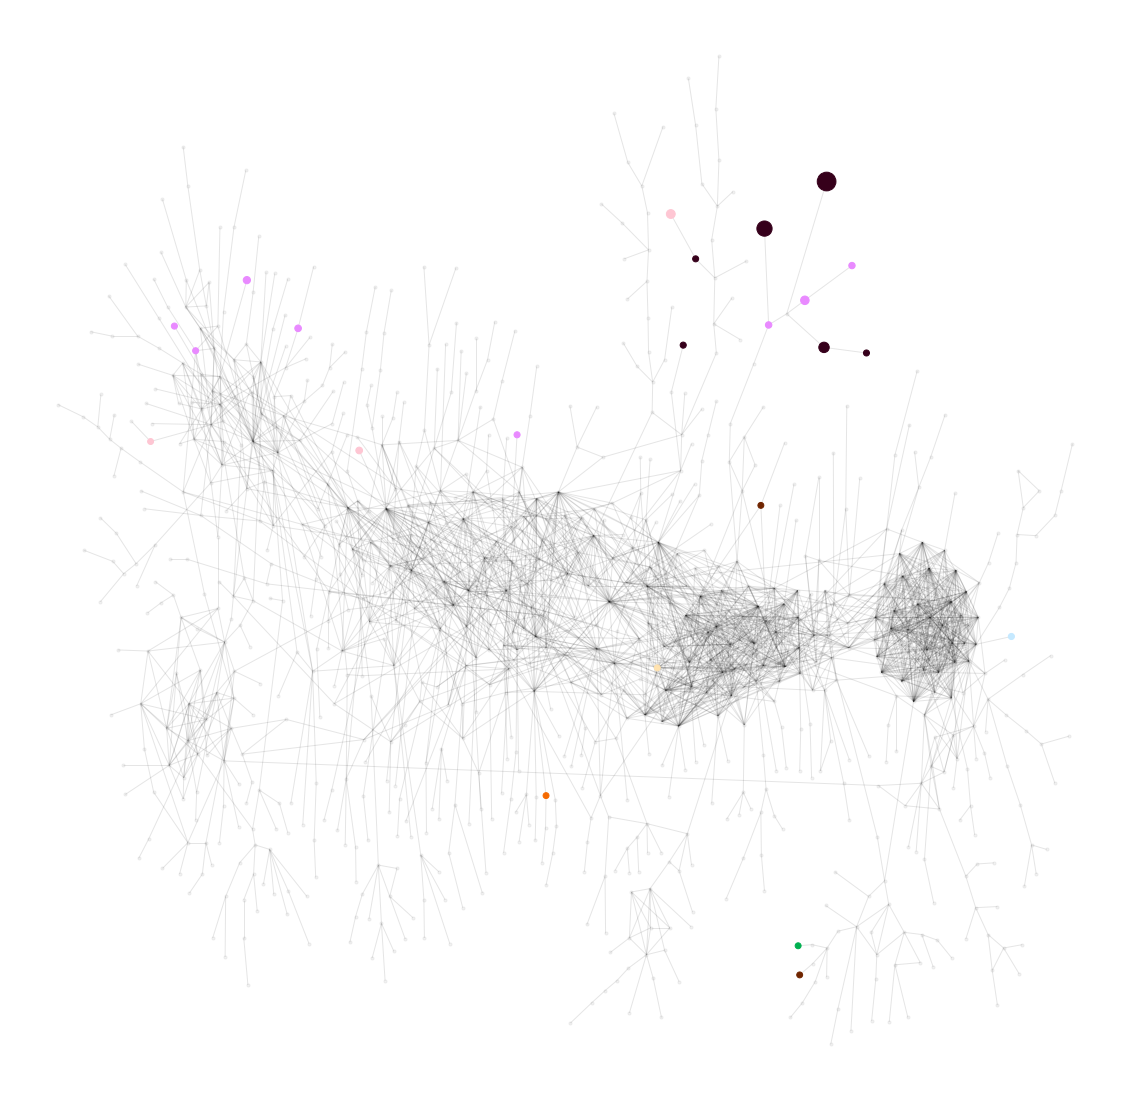

In [ ]:
# Plot in the product space
create_product_space(df_plot_dataframe=df_ps,
                     df_plot_node_col='product_code',
                     df_node_size_col='export_value',
                     )

##### Product space with legend



Below is a legend of the product space. There&rsquo;s also a &rsquo;show legend&rsquo; option in the &rsquo;create product space&rsquo; function but this option needs to be updated.

![img](https://www.dropbox.com/s/lf4lf8ktqahnovg/Selection_032.png?dl=1)

To see exactly what node represents what product, use the Atlas for now by hovering with the mouse over a node:

[https://atlas.cid.harvard.edu/explore/network?country=186&year=2018&productClass=HS&product=undefined&startYear=undefined&target=Product&partner=undefined](https://atlas.cid.harvard.edu/explore/network?country=186&year=2018&productClass=HS&product=undefined&startYear=undefined&target=Product&partner=undefined)

(This can also be implemented through Python by exporting to html instead of as an image, but not implemented above yet)

## Predicting diversification of countries: densities / density regressions



Will be completed 



## Calculating Economic Complexity / Product Complexity



We know from the product space and density regressions how products are related to one another and how that matters for diversification of countries.

The next step is to look at which parts of the product space are most interesting to ultimately reach / diversify into. Generally complex products are located in the center of the product space, and countries with a higher economic complexity tend to have higher economic growth.

![img](imgs/complex_products_in_product_space.png)

![img](https://www.dropbox.com/s/a231jw76yocjkkr/complex_products_in_product_space.png?dl=1)

Recall from the lecture that the economic complexity index (ECI) and product complexity index (PCI) measures are derived from an iterative method of reflections algorithm on country diversity and product ubiquity (Hidalgo Hausmann 2009), or finding the eigenvalues of a country-product matrix (Mealy et al. 2019)

![img](/home/linux/Dropbox/proj/org_zhtml_projects/product-space-eci-workshop/imgs/countries_products_eci.png)

![img](https://www.dropbox.com/s/dte4vwgk4tvj3rd/countries_products_eci.png?dl=1)

The STATA package to calculate this - by Sebastian Bustos and Muhammed Yildirim - is available at:

[https://github.com/cid-harvard/ecomplexity](https://github.com/cid-harvard/ecomplexity)

The Python package to calculate this - by Shreyas Gadgin Matha - is available at [https://github.com/cid-harvard/py-ecomplexity](https://github.com/cid-harvard/py-ecomplexity)

(One can also directly download the PCI value for every product from the Atlas data repository - the ECI of a country is the mean of the PCI values of the products it has a comparative advantage in.)



### Using the &rsquo;py-ecomplexity&rsquo; package



#### Installation



One can install it by pointing pip (package-management system in Python) to the respective library, using the following command:

In [23]:
!pip install ecomplexity
print('installed py-ecomplexity')

  Preparing metadata (setup.py) ... done
  Using cached pandas-1.4.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
  Using cached numpy-1.23.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached pytz-2022.1-py2.py3-none-any.whl (503 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Created wheel for ecomplexity: filename=ecomplexity-0.5.2-py3-none-any.whl size=11268 sha256=bdc59bce7f355b45d061c0fa7e2fc0b60e09389868cbacc5790241371e8cc604
  Stored in directory: /home/repl/.cache/pip/wheels/ed/de/db/5b919104e9efd3982dc5c242da01fe379b4f3c2e2a244c8a09
Successfully built ecomplexity
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
redshift-connector 2.0.900 requires pytz<2021.9,>=2020.1, but you have pytz 2022.1 which is incompatible.
python

#### Usage



We will again use again the original trade dataset (df<sub>orig</sub>), below.

In [ ]:
from ecomplexity import ecomplexity
from ecomplexity import proximity

# To use py-ecomplexity, specify the following columns
trade_cols = {'time':'year',
              'loc':'country_name',
              'prod':'product_name',
              'val':'export_value'}
              
# Then run the command
print('calculating ecomplexity')
df_ec = ecomplexity(df_orig, trade_cols)
print('finished calculating')

# Keep selected columns
df_ec = df_ec[['country_name',
               'product_name',
               'product_code',
               'export_value',
               'year',
               'pci',
               'eci']]

# Show results
df_ec.sample(n=10)

### Complexity weighted by destination (example: Ukraine)



You can also calculate economic complexity by destination.

In a paper with Frank Neffke and Ernesto Lopez-Cordova we did this to explore opportunities for Ukraine (to connect to European value chains):

[https://growthlab.cid.harvard.edu/publications/assessing-ukraines-role-european-value-chains-gravity-equation-cum-economic](https://growthlab.cid.harvard.edu/publications/assessing-ukraines-role-european-value-chains-gravity-equation-cum-economic)

(Using the ECI by destination we found that highly complex products from Ukraine in the 2000s were typically destined for the Russian market, which was also one of the largest importers of products from Ukraine. The detoriation in relations with Russia led to a significant decline in exports there from 2011 onwards, resulting in Ukraine suffering from not only a quantitative but also a qualitative decline in exports).

Hidalgo and Hausmann (2009) calculate complexity of country $c$ as the average PCI of all products for which ${RCA}_{cp}>1$.

Below we define it as the weighted average PCI, where weights are given by the value of country $c$’s exports in each product. This allows us to define an ECI for separate export markets.

Let $\mathcal{M}$ be the set of countries that together constitute an export market (say, the EU&rsquo;s Single Market). Now, the destination-market specific ECI for country $c$ is defined as:

\begin{equation} \label{e_ECI}
ECI_{c}^{\mathcal{M}}=\sum \limits_{p} \frac{\sum \limits_{d \in \mathcal{M}} X^{d}_{op}}{\sum \limits_{d \in \mathcal{M}} X^{d}_{o}} {PCI}_{p}   
\end{equation}

where $X_{op}^{d}$ represents the exports of product $p$ from exporter $o$ to importer $d$ and an omitted subscript indicates the summation over the omitted category: $X_{o}^{d}=\sum \limits_{p} X_{op}^{d}$.

To calculate this, we need a dataset that has country exports **per destination** for this, which is available in the Growth Lab&rsquo;s DataVerse as:

    "country_partner_hsproduct4digit_years_2000_2016.csv"

As this file above is 16 gigabytes, we will load a version of it for only Ukraine&rsquo;s exports. This file has been processed outside of Google colab using the code below:

    df = pd.read_csv('country_partner_hsproduct4digit_years_2000_2016.csv')
    df = df[df['location_code_code']=='UKR')
    df = df[df['export_value']>0]
    df.to_csv('ukr_exports_per_destination.csv',index=False)

In [ ]:
print(f'loading data (from dropbox)')
df_ukr = pd.read_csv('https://www.dropbox.com/s/megm8qzn3jcwnqz/ukr_exports_per_destination.csv?dl=1')
print('loaded')

# show 10 random rows
df_ukr.sample(n=10)

Merge PCI from products in 2000 into the dataframe (from df<sub>ec</sub> created in previous section using py-ecomplexity).

In [ ]:
# -- to merge, add leading zeroes to dataset, e.g. 303 will be 0303
df_ukr.loc[ (df_ukr['hs_product_code'].astype(str).str.len()==3), 'hs_product_code']= '0'+ df_ukr['hs_product_code'].astype(str)
# -- remove leading / trailing spaces
df_ukr['hs_product_code'] = df_ukr['hs_product_code'].astype(str).str.strip()
# -- keep pcis from products in 2000
df_pci = df_ec[df_ec['year']==2000][['product_code','pci']].drop_duplicates(subset='product_code')
# -- merge pcis into the dataframe
df_ukr = pd.merge(df_ukr,df_pci[['product_code','pci']],how='left',left_on=f'hs_product_code',right_on=f'product_code',indicator=True)
# check merge 'left-only','right-only','both' counts (always do this to cross-check the merge)
df_ukr['_merge'].value_counts()

Now we calculate the ECI by destination.

In [ ]:
def calc_ecimc(data,origin_col,destination_col,product_col,value_col,pci_col):
    """
    Calculates economic complexity by destination (the weighted-by-exports-to-destination average PCI).

    Needs a year-origin-destination-product-exportvalue-pci dataframe as input.

    Returns:
        pandas dataframe with ecim
    """
    dft = data.copy()
    dft['export_value_cot'] = dft.groupby([origin_col,destination_col])[value_col].transform('sum')
    dft['pci_x_export'] = dft[pci_col] * dft[value_col]
    dft['pci_x_export_sum'] = dft.groupby([origin_col,destination_col])['pci_x_export'].transform('sum')
    dft['eciMc'] = dft['pci_x_export_sum']/dft['export_value_cot']
    dft.drop_duplicates(subset=[origin_col,destination_col],inplace=True)
    dft = dft[[origin_col,destination_col,'eciMc']]

    return dft

df_ukr_ecimc = calc_ecimc(data=df_ukr,
                          origin_col='location_code',
                          destination_col= 'partner_code',
                          product_col='hs_product_code',
                          value_col='export_value',
                          pci_col = 'pci'
                        )

# Show 10 random rows
df_ukr_ecimc.sample(n=20)

Map economic complexity of Ukraine&rsquo;s exports by destination.

In [ ]:
path = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(path)
# merge complexities into it
world = pd.merge(world,df_ukr_ecimc[df_ukr_ecimc['eciMc']<3],how='left',left_on=f'iso_a3',right_on='partner_code',indicator=True)
fig, ax = plt.subplots(1, 1,figsize=(15,15))
plt.axis('off')
# https://matplotlib.org/stable/tutorials/colors/colormapnorms.html
cmap = cm.coolwarm
world.plot(column='eciMc', ax=ax, legend=True,cmap=cmap)
plt.show()

Highly complex products are typically destined for the Russian market, which is also one of the largest importers of products from Ukraine.

The detoriation in relations with Russia led to a significant decline in exports there from 2011 onwards:
![img](https://www.dropbox.com/s/xfl3gig3zxer0fm/total_exports_Ukraine_over_years.png?dl=1)

As a result, Ukraine suffers from not only a quantitative but also a qualitative decline in exports. In the paper we explore new opportunities for Ukraine.

Note: double-check political controversies when using geopandas!

![img](https://www.dropbox.com/s/twtl8p5ksgfezm0/map_ukraine.png?dl=1)